# Logistic Regression

In [1]:
# 下载资料并做normalize，切为Training set和validation set
import numpy as np

np.random.seed(0)

x_train_fpath = '../data/X_train'
y_train_fpath = '../data/Y_train'
x_test_fpath  = '../data/X_test'

# 第一行是feature的名称，所以先执行next(f)跳过第一行的内容；第一个dimension是id，feature[1:]从第二个dimension开始读取
with open(x_train_fpath) as f:
    next(f)
    x_train = np.array([line.strip('\n').split(',')[1:]  for line in f], dtype = float)

with open(y_train_fpath) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1]  for line in f], dtype = float)
    
with open(x_test_fpath) as f:
    next(f)
    x_test = np.array([line.strip('\n').split(',')[1:]   for line in f], dtype = float)
    
print('x_train :\n',x_train,x_train.shape,'\n')
print('y_train :\n',y_train,y_train.shape,'\n')
print('x_test :\n',x_test,x_test.shape)

x_train :
 [[33.  1.  0. ... 52.  0.  1.]
 [63.  1.  0. ... 52.  0.  1.]
 [71.  0.  0. ...  0.  0.  1.]
 ...
 [16.  0.  0. ...  8.  1.  0.]
 [48.  1.  0. ... 52.  0.  1.]
 [48.  0.  0. ...  0.  0.  1.]] (54256, 510) 

y_train :
 [1. 0. 0. ... 0. 0. 0.] (54256,) 

x_test :
 [[37.  1.  0. ... 52.  0.  1.]
 [48.  1.  0. ... 52.  0.  1.]
 [68.  0.  0. ...  0.  1.  0.]
 ...
 [38.  1.  0. ... 52.  0.  1.]
 [17.  0.  0. ... 40.  1.  0.]
 [22.  0.  0. ... 25.  1.  0.]] (27622, 510)


In [2]:
def _normalize(x, train = True, specified_column = None, x_mean = None, x_std = None):
    '''
    This function normalizes specific columns of x
    注意，testing data要跟training data的normalize方式一致，要用training data的mean和std，
    因此还需要input已知的x_mean和x_std
    '''
    # 如果没有指定列，那就穷举所有列，这里np.arange类似于range函数，只不过前者创造的对象是array类型
    if specified_column == None:
        specified_column = np.arange(x.shape[1])
    
    # train=True: for training data; train=False: for testing data，只计算training data的mean和std
    if train:
        # axis=0，对指定列求mean，注意np.mean返回的是一个列向量，因此需要用reshape(1,-1)转化成行向量
        x_mean = np.mean(x[:, specified_column], axis = 0).reshape(1, -1)
        # axis=0，对指定列求std
        x_std  = np.std(x[:, specified_column], axis = 0).reshape(1, -1)
     
    # 对指定列进行normalize，注意相减的两个向量行数不同但列数相同，相当于前者的每一行都减去x_mean这个行向量，除法同理
    # 分母加一个很小很小的数是为了避免标准差为0
    x[:, specified_column] = (x[:, specified_column] - x_mean) / (x_std + 1e-8)
    
    return x, x_mean, x_std

In [3]:
def _train_split(x, y, validation_ratio = 0.25):
    '''
    This function splits data into training set and validation set
    '''
    train_size = int(len(x) * (1 - validation_ratio))
    
    #return x,y of training set and validation set  
    # 如果返回值为x[:train_size, :]的话会报错，但这两种形式本质上是一样的，存疑
    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]

In [4]:
# normalize training data and testing data
x_train, x_mean, x_std = _normalize(x_train, train = True)
x_test, _, _ = _normalize(x_test, train = False, x_mean = x_mean, x_std = x_std)

# split training data into training set and validation set
x_training_set, y_training_set, x_validation_set, y_validation_set = _train_split(x_train, y_train, validation_ratio = 0.1)

print('x_training_set : ', x_training_set.shape, '\n', x_training_set)
print('------------------------------------------------------------------------')
print('y_training_set : ', y_training_set.shape, '\n', y_training_set)
print('------------------------------------------------------------------------')
print('x_validation_set : ', x_validation_set.shape, '\n', x_validation_set)
print('------------------------------------------------------------------------')
print('y_validation_set : ', y_validation_set.shape, '\n', y_validation_set)

x_training_set :  (48830, 510) 
 [[-0.42755297  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 1.19978056  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 1.63373617 -1.00040555 -0.1822401  ... -1.45536172 -1.01485522
   1.01485522]
 ...
 [ 0.65733605 -1.00040555 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]
 [ 0.27762489  0.99959458 -0.1822401  ...  0.28450104 -1.01485522
   1.01485522]
 [ 0.16913599 -1.00040555 -0.1822401  ...  0.80645987  0.98536219
  -0.98536219]]
------------------------------------------------------------------------
y_training_set :  (48830,) 
 [1. 0. 0. ... 1. 0. 0.]
------------------------------------------------------------------------
x_validation_set :  (5426, 510) 
 [[-0.48179742  0.99959458 -0.1822401  ...  0.80645987  0.98536219
  -0.98536219]
 [-1.24121974 -1.00040555  5.48726602 ...  0.80645987 -1.01485522
   1.01485522]
 [-0.04784181  0.99959458 -0.1822401  ...  0.80645987 -1.01485522
   1.01485522]

In [5]:
# some useful functions
# np.dot()的作用主要体现在两个1-D向量相乘和一个N-D矩阵和一个1-D向量相乘的情景下：
# 两个1-D向量A与B相乘(A、B元素数量必须相等)：等价于A、B对应元素相乘并累计求和，最终得到一个常量积；注意A*B和np.dot(A,B)的区别，前者是A、B对应元素相乘，每次相乘的积都作为新的1-D向量的一个元素，而不是把这些积累加为一个常量
# 一个N-D矩阵A和一个1-D向量B相乘(A的每一行元素数量必须与B的元素数量相等)：等价于把这个N-D矩阵A拆成N个1-D向量，它们分别与B做1-D矩阵的相乘，得到的积作为结果的一个元素，总共有N个积，最终的结果就是由这N个积组成的1-D向量
# np.dot()在w*x上的应用可以减少转置，在其他方面也有比较便利的应用
def _shuffle(x, y):
    '''
    This function shuffles two equal-length list/array, x and y, together
    '''
    # 打乱原本的次序
    randomize = np.arange(len(x))
    np.random.shuffle(randomize)
    
    return x[randomize], y[randomize]

def _sigmoid(z):
    '''
    sigmoid function can be used to calculate probability
    To avoid overflow, minimum/maximum output value is set
    '''
    # np.clip(a, a_min, a_max)将数组a限制在a_min和a_max之间，超出范围的值将被赋以边界值
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1 - (1e-6))

def _f(x, w, b):
    '''
    logistic regression function, parameterized by w and b
    
    Arguements:
        X: input data, shape = [batch_size, data_dimension]
        w: weight vector, shape = [data_dimension, ]
        b: bias, scalar
    output:
        predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    '''
    # np.dot特别适合用来计算x*w，无需转置，直接就是N维x的每一行与一维w相乘得到的结果汇总成一个一维的y
    return _sigmoid(np.dot(x, w) + b)

def _predict(x, w, b):
    '''
    This function returns a truth value prediction for each row of x
    by round function to make 0 or 1
    '''
    # 利用round函数的四舍五入功能把概率转化成0或1
    return np.round(_f(x, w, b)).astype(np.int)
    
def _accuracy(y_predict, y_label):
    '''
    This function calculates prediction accuracy
    '''
    # 预测值和标签值相减，取绝对值后再求平均，相当于预测错误的个数(差为1)/总个数，即错误率，1-错误率即正确率
    acc = 1 - np.mean(np.abs(y_predict - y_label))
    
    return acc

In [6]:
# loss function(cross_entropy) and gradient
def _cross_entropy_loss(y_predict, y_label):
    '''
    This function computes the cross entropy 
    
    Arguements:
        y_pred: probabilistic predictions, float vector
        Y_label: ground truth labels, bool vector
    Output:
        cross entropy, scalar    
    '''
    # cross_entropy = -Σ(y_head*ln(y)+(1-y_head)*ln(1-y))
    # 注意，这里的np.dot可以直接计算两个一位矩阵的积(前提是元素个数一致)，无需转置；np.log()等价于ln()
    # 因此这里的矩阵积实际上已经做了Σ的工作，左边的np.dot计算的是Σ(y_head*ln(y)，右边的np.dot计算的是Σ(1-y_head)*ln(1-y))
    cross_entropy = -(np.dot(y_label, np.log(y_predict)) + np.dot((1 - y_label), np.log(1 - y_predict)))
    
    return cross_entropy

def _gradient(x, y_label, w, b):
    '''
    This function computes the gradient of cross entropy loss with respect to weight w and bias b
    loss function: -Σ (y_head*ln(y)+(1-y_head)*ln(1-y)), 分别对w和b求偏微分，可得
    gradient of w: -Σ（y_head - y)*x
    gradient of b: -Σ（y_head - y)
    '''
    y_predict = _f(x, w, b)
    # 也可以是w_gradient = -np.dot(x.T, y_label - y_predict)
    w_gradient = -np.sum((y_label - y_predict) * x.T, 1)
    b_gradient = -np.sum(y_label - y_predict)
    
    return w_gradient, b_gradient

In [7]:
# mini-batch stochastic-gradient-descent

train_size = x_training_set.shape[0]
validation_size = x_validation_set.shape[0]
dim = x_training_set.shape[1]
# initialize w and b
w = np.zeros(dim)
b= np.zeros(1)

# parameters for training
max_iter = 100
batch_size = 10
learning_rate = 1

# save the loss and accuracy
training_set_loss = []
training_set_acc = []
validation_set_loss = []
validation_set_acc = []

w_adagrad = 1e-8
b_adagrad = 1e-8

# calcuate the number of parameter updates
step = 1

# training for iterations
for epoch in range(max_iter):
    # random shuffle at the beginning of each epoch
    x_training_set, y_training_set = _shuffle(x_training_set, y_training_set)
    
    # mini-batch training
    for i in range(int(np.floor(train_size / batch_size))):
        # get the mini-batch
        x = x_training_set[i * batch_size : (i + 1) * batch_size]
        y = y_training_set[i * batch_size : (i + 1) * batch_size]
        
        # compute the gradient
        w_gradient, b_gradient = _gradient(x, y, w, b)
        
        # compute the adagrad
        w_adagrad = w_adagrad + np.power(w_gradient, 2)
        b_adagrad = b_adagrad + np.power(b_gradient, 2)
        
        # gradient descent update 
        # learning rate decay with time
        w = w - learning_rate * w_gradient / np.sqrt(w_adagrad)
        b = b - learning_rate * b_gradient / np.sqrt(b_adagrad)
        
        step = step + 1
        
    # one epoch: compute loss and accuracy of training set and validation set
    y_training_predict = _predict(x_training_set, w, b) # predict函数将Probability取round，只剩下0和1
    y_probability = _f(x_training_set, w, b) # Probability用来计算cross_entropy，不能用round后的值，否则会出现ln(0)的错误
    acc = _accuracy(y_training_predict, y_training_set)
    loss = _cross_entropy_loss(y_probability, y_training_set) / train_size # average cross_entropy
    training_set_acc.append(acc)
    training_set_loss.append(loss)
    print('training_set_acc_%d   : %f \t training_set_loss_%d  : %f'%(epoch, acc, epoch, loss))
    
    y_validation_predict = _predict(x_validation_set, w, b)
    y_probability = _f(x_validation_set, w, b)
    acc = _accuracy(y_validation_predict, y_validation_set)
    loss = _cross_entropy_loss(y_probability, y_validation_set) / validation_size # average cross_entropy
    validation_set_acc.append(acc)
    validation_set_loss.append(loss)
    
# validation_set的acc和loss只输出最后那一次
print('validation_set_acc_%d : %f \t validation_set_loss_%d : %f'%(epoch, acc, epoch, loss))
print()
   

training_set_acc_0   : 0.853758 	 training_set_loss_0  : 1.231238


/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


training_set_acc_1   : 0.860557 	 training_set_loss_1  : 0.861367
training_set_acc_2   : 0.858919 	 training_set_loss_2  : 0.691638
training_set_acc_3   : 0.862216 	 training_set_loss_3  : 0.524193
training_set_acc_4   : 0.867827 	 training_set_loss_4  : 0.447262
training_set_acc_5   : 0.865574 	 training_set_loss_5  : 0.409718
training_set_acc_6   : 0.868093 	 training_set_loss_6  : 0.382282
training_set_acc_7   : 0.868913 	 training_set_loss_7  : 0.357397
training_set_acc_8   : 0.869097 	 training_set_loss_8  : 0.352555
training_set_acc_9   : 0.870879 	 training_set_loss_9  : 0.352337
training_set_acc_10   : 0.870858 	 training_set_loss_10  : 0.339295
training_set_acc_11   : 0.872128 	 training_set_loss_11  : 0.335619
training_set_acc_12   : 0.872783 	 training_set_loss_12  : 0.330857
training_set_acc_13   : 0.877289 	 training_set_loss_13  : 0.321833
training_set_acc_14   : 0.872353 	 training_set_loss_14  : 0.330259
training_set_acc_15   : 0.876818 	 training_set_loss_15  : 0.32081

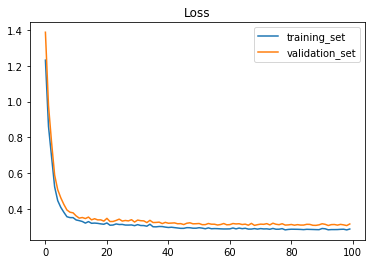

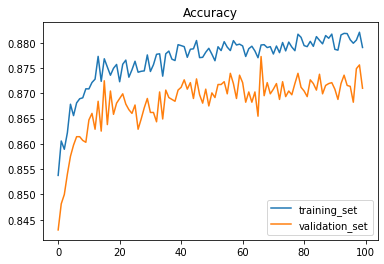

In [8]:
import matplotlib.pyplot as plt
# loss curve
plt.plot(training_set_loss)
plt.plot(validation_set_loss)
plt.title('Loss')
plt.legend(['training_set', 'validation_set'])
plt.savefig('loss_sgd.png')
plt.show()

# accuracy curve
plt.plot(training_set_acc)
plt.plot(validation_set_acc)
plt.title('Accuracy')
plt.legend(['training_set', 'validation_set'])
plt.savefig('acc_sgd.png')
plt.show()

In [9]:
# mini-batch stochastic-gradient-descent

train_size = x_train.shape[0]
dim = x_train.shape[1]
# initialize w and b
w = np.zeros(dim)
b= np.zeros(1)

# parameters for training
max_iter = 1000
batch_size = 10
learning_rate = 1

# save the loss and accuracy
train_loss = []
train_acc = []

w_adagrad = 1e-8
b_adagrad = 1e-8


# training for iterations
for epoch in range(max_iter):
    # random shuffle at the beginning of each epoch
    x_train, y_train = _shuffle(x_train, y_train)
    
    # mini-batch training
    for i in range(int(np.floor(train_size / batch_size))):
        # get the mini-batch
        x = x_train[i * batch_size : (i + 1) * batch_size]
        y = y_train[i * batch_size : (i + 1) * batch_size]
        
        # compute the gradient
        w_gradient, b_gradient = _gradient(x, y, w, b)
        
        # compute the adagrad
        w_adagrad = w_adagrad + np.power(w_gradient, 2)
        b_adagrad = b_adagrad + np.power(b_gradient, 2)
        
        # gradient descent update 
        # learning rate decay with time
        w = w - learning_rate * w_gradient / np.sqrt(w_adagrad)
        b = b - learning_rate * b_gradient / np.sqrt(b_adagrad)
    
    # one epoch: compute loss and accuracy of training set and validation set
    y_train_predict = _predict(x_train, w, b) # predict函数将Probability取round，只剩下0和1
    y_probability = _f(x_train, w, b) # Probability用来计算cross_entropy，不能用round后的值，否则会出现ln(0)的错误
    acc = _accuracy(y_train_predict, y_train)
    loss = _cross_entropy_loss(y_probability, y_train) / train_size # average cross_entropy
    train_acc.append(acc)
    train_loss.append(loss)
    print('train_acc_%d   : %f \t train_loss_%d  : %f'%(epoch, acc, epoch, loss))
        

train_acc_0   : 0.853030 	 train_loss_0  : 1.019115
train_acc_1   : 0.858191 	 train_loss_1  : 0.669045


/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


train_acc_2   : 0.860992 	 train_loss_2  : 0.503907
train_acc_3   : 0.860439 	 train_loss_3  : 0.428062
train_acc_4   : 0.862467 	 train_loss_4  : 0.392275
train_acc_5   : 0.866540 	 train_loss_5  : 0.363953
train_acc_6   : 0.867959 	 train_loss_6  : 0.366984
train_acc_7   : 0.869342 	 train_loss_7  : 0.355468
train_acc_8   : 0.868236 	 train_loss_8  : 0.357612
train_acc_9   : 0.871332 	 train_loss_9  : 0.345363
train_acc_10   : 0.870853 	 train_loss_10  : 0.349772
train_acc_11   : 0.871719 	 train_loss_11  : 0.337862
train_acc_12   : 0.872770 	 train_loss_12  : 0.333541
train_acc_13   : 0.872880 	 train_loss_13  : 0.336149
train_acc_14   : 0.871314 	 train_loss_14  : 0.331026
train_acc_15   : 0.873157 	 train_loss_15  : 0.327797
train_acc_16   : 0.871940 	 train_loss_16  : 0.325359
train_acc_17   : 0.874152 	 train_loss_17  : 0.324021
train_acc_18   : 0.873968 	 train_loss_18  : 0.324049
train_acc_19   : 0.870024 	 train_loss_19  : 0.326234
train_acc_20   : 0.873415 	 train_loss_20  :

train_acc_153   : 0.882207 	 train_loss_153  : 0.276491
train_acc_154   : 0.881543 	 train_loss_154  : 0.276773
train_acc_155   : 0.881211 	 train_loss_155  : 0.277223
train_acc_156   : 0.881783 	 train_loss_156  : 0.275096
train_acc_157   : 0.882207 	 train_loss_157  : 0.274911
train_acc_158   : 0.880695 	 train_loss_158  : 0.277639
train_acc_159   : 0.882354 	 train_loss_159  : 0.275658
train_acc_160   : 0.880695 	 train_loss_160  : 0.276704
train_acc_161   : 0.882243 	 train_loss_161  : 0.275589
train_acc_162   : 0.882207 	 train_loss_162  : 0.276237
train_acc_163   : 0.882889 	 train_loss_163  : 0.275353
train_acc_164   : 0.881432 	 train_loss_164  : 0.276682
train_acc_165   : 0.881248 	 train_loss_165  : 0.275659
train_acc_166   : 0.881525 	 train_loss_166  : 0.275458
train_acc_167   : 0.880714 	 train_loss_167  : 0.276736
train_acc_168   : 0.882151 	 train_loss_168  : 0.276014
train_acc_169   : 0.882575 	 train_loss_169  : 0.274924
train_acc_170   : 0.882741 	 train_loss_170  : 0

train_acc_300   : 0.882852 	 train_loss_300  : 0.270833
train_acc_301   : 0.882889 	 train_loss_301  : 0.272400
train_acc_302   : 0.882999 	 train_loss_302  : 0.271064
train_acc_303   : 0.883460 	 train_loss_303  : 0.271337
train_acc_304   : 0.882962 	 train_loss_304  : 0.271516
train_acc_305   : 0.883699 	 train_loss_305  : 0.271270
train_acc_306   : 0.883589 	 train_loss_306  : 0.272215
train_acc_307   : 0.883386 	 train_loss_307  : 0.271610
train_acc_308   : 0.883515 	 train_loss_308  : 0.271624
train_acc_309   : 0.883331 	 train_loss_309  : 0.271059
train_acc_310   : 0.882004 	 train_loss_310  : 0.273356
train_acc_311   : 0.883257 	 train_loss_311  : 0.271488
train_acc_312   : 0.881561 	 train_loss_312  : 0.272709
train_acc_313   : 0.883294 	 train_loss_313  : 0.272042
train_acc_314   : 0.883534 	 train_loss_314  : 0.272161
train_acc_315   : 0.882501 	 train_loss_315  : 0.272152
train_acc_316   : 0.883220 	 train_loss_316  : 0.272008
train_acc_317   : 0.882391 	 train_loss_317  : 0

train_acc_447   : 0.883534 	 train_loss_447  : 0.270311
train_acc_448   : 0.883939 	 train_loss_448  : 0.269612
train_acc_449   : 0.883699 	 train_loss_449  : 0.269310
train_acc_450   : 0.883847 	 train_loss_450  : 0.271333
train_acc_451   : 0.882944 	 train_loss_451  : 0.269474
train_acc_452   : 0.883128 	 train_loss_452  : 0.269762
train_acc_453   : 0.883958 	 train_loss_453  : 0.270153
train_acc_454   : 0.884639 	 train_loss_454  : 0.269226
train_acc_455   : 0.883681 	 train_loss_455  : 0.269658
train_acc_456   : 0.883018 	 train_loss_456  : 0.270036
train_acc_457   : 0.882170 	 train_loss_457  : 0.270015
train_acc_458   : 0.883718 	 train_loss_458  : 0.269031
train_acc_459   : 0.884418 	 train_loss_459  : 0.269432
train_acc_460   : 0.882483 	 train_loss_460  : 0.269515
train_acc_461   : 0.884087 	 train_loss_461  : 0.269990
train_acc_462   : 0.883386 	 train_loss_462  : 0.268985
train_acc_463   : 0.883552 	 train_loss_463  : 0.269506
train_acc_464   : 0.883460 	 train_loss_464  : 0

train_acc_594   : 0.882889 	 train_loss_594  : 0.270063
train_acc_595   : 0.885192 	 train_loss_595  : 0.268367
train_acc_596   : 0.883792 	 train_loss_596  : 0.268691
train_acc_597   : 0.883829 	 train_loss_597  : 0.268781
train_acc_598   : 0.884639 	 train_loss_598  : 0.269043
train_acc_599   : 0.884087 	 train_loss_599  : 0.268761
train_acc_600   : 0.884769 	 train_loss_600  : 0.269324
train_acc_601   : 0.883276 	 train_loss_601  : 0.268976
train_acc_602   : 0.883276 	 train_loss_602  : 0.268839
train_acc_603   : 0.883902 	 train_loss_603  : 0.269171
train_acc_604   : 0.884252 	 train_loss_604  : 0.268793
train_acc_605   : 0.883902 	 train_loss_605  : 0.268654
train_acc_606   : 0.884566 	 train_loss_606  : 0.268372
train_acc_607   : 0.884418 	 train_loss_607  : 0.268607
train_acc_608   : 0.884437 	 train_loss_608  : 0.268724
train_acc_609   : 0.883958 	 train_loss_609  : 0.268884
train_acc_610   : 0.883534 	 train_loss_610  : 0.268494
train_acc_611   : 0.884381 	 train_loss_611  : 0

train_acc_741   : 0.884621 	 train_loss_741  : 0.269250
train_acc_742   : 0.884658 	 train_loss_742  : 0.268414
train_acc_743   : 0.884326 	 train_loss_743  : 0.268409
train_acc_744   : 0.885192 	 train_loss_744  : 0.268670
train_acc_745   : 0.884400 	 train_loss_745  : 0.268529
train_acc_746   : 0.884842 	 train_loss_746  : 0.268000
train_acc_747   : 0.884418 	 train_loss_747  : 0.268983
train_acc_748   : 0.884289 	 train_loss_748  : 0.268329
train_acc_749   : 0.884087 	 train_loss_749  : 0.268470
train_acc_750   : 0.884142 	 train_loss_750  : 0.268462
train_acc_751   : 0.883958 	 train_loss_751  : 0.268943
train_acc_752   : 0.884050 	 train_loss_752  : 0.268659
train_acc_753   : 0.884345 	 train_loss_753  : 0.268478
train_acc_754   : 0.884087 	 train_loss_754  : 0.268256
train_acc_755   : 0.884566 	 train_loss_755  : 0.268068
train_acc_756   : 0.884068 	 train_loss_756  : 0.268665
train_acc_757   : 0.883534 	 train_loss_757  : 0.269026
train_acc_758   : 0.884308 	 train_loss_758  : 0

train_acc_888   : 0.884695 	 train_loss_888  : 0.268204
train_acc_889   : 0.883368 	 train_loss_889  : 0.268919
train_acc_890   : 0.883921 	 train_loss_890  : 0.267801
train_acc_891   : 0.884510 	 train_loss_891  : 0.268205
train_acc_892   : 0.882594 	 train_loss_892  : 0.269547
train_acc_893   : 0.883847 	 train_loss_893  : 0.268268
train_acc_894   : 0.883902 	 train_loss_894  : 0.268403
train_acc_895   : 0.884639 	 train_loss_895  : 0.268063
train_acc_896   : 0.884658 	 train_loss_896  : 0.268219
train_acc_897   : 0.884824 	 train_loss_897  : 0.268108
train_acc_898   : 0.884105 	 train_loss_898  : 0.268703
train_acc_899   : 0.884234 	 train_loss_899  : 0.268052
train_acc_900   : 0.884123 	 train_loss_900  : 0.267747
train_acc_901   : 0.884805 	 train_loss_901  : 0.269010
train_acc_902   : 0.883976 	 train_loss_902  : 0.268114
train_acc_903   : 0.884713 	 train_loss_903  : 0.268241
train_acc_904   : 0.884142 	 train_loss_904  : 0.268129
train_acc_905   : 0.883792 	 train_loss_905  : 0

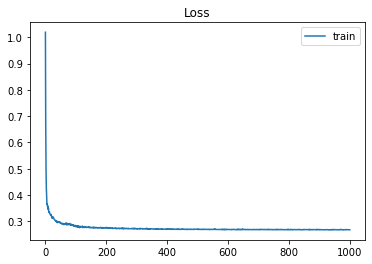

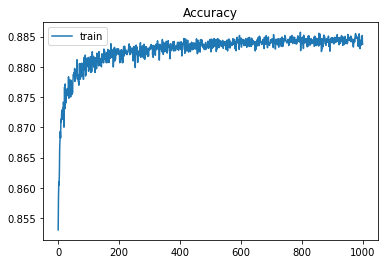

In [10]:
# loss curve
plt.plot(train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.show()

# accuracy curve
plt.plot(train_acc)
plt.title('Accuracy')
plt.legend(['train'])
plt.show()

np.save('weight_adagrad_sgd.npy', w)
np.save('bias_adagrad_sgd.npy', b)

In [11]:
# predict testing data
import csv
w = np.load('weight_adagrad_sgd.npy')
b = np.load('bias_adagrad_sgd.npy')
y_test_predict = _predict(x_test, w, b)
print(y_test_predict, y_test_predict.shape)

with open('predict_adagrad_sgd.csv', mode = 'w', newline = '') as f:
    csv_writer = csv.writer(f)
    header = ['id', 'label']
    print(header)
    csv_writer.writerow(header)
    for i in range(y_test_predict.shape[0]):
        row = [str(i), y_test_predict[i]]
        csv_writer.writerow(row)
        print(row)

/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


[0 0 0 ... 1 0 0] (27622,)
['id', 'label']
['0', 0]
['1', 0]
['2', 0]
['3', 0]
['4', 0]
['5', 1]
['6', 0]
['7', 1]
['8', 0]
['9', 0]
['10', 0]
['11', 0]
['12', 1]
['13', 0]
['14', 0]
['15', 0]
['16', 0]
['17', 0]
['18', 0]
['19', 0]
['20', 1]
['21', 0]
['22', 0]
['23', 0]
['24', 0]
['25', 0]
['26', 0]
['27', 0]
['28', 0]
['29', 0]
['30', 0]
['31', 0]
['32', 0]
['33', 1]
['34', 0]
['35', 0]
['36', 0]
['37', 0]
['38', 0]
['39', 0]
['40', 0]
['41', 0]
['42', 1]
['43', 0]
['44', 0]
['45', 0]
['46', 0]
['47', 0]
['48', 0]
['49', 0]
['50', 0]
['51', 0]
['52', 0]
['53', 0]
['54', 0]
['55', 0]
['56', 0]
['57', 0]
['58', 0]
['59', 0]
['60', 0]
['61', 0]
['62', 0]
['63', 0]
['64', 0]
['65', 0]
['66', 0]
['67', 0]
['68', 1]
['69', 0]
['70', 0]
['71', 0]
['72', 0]
['73', 0]
['74', 0]
['75', 0]
['76', 0]
['77', 1]
['78', 1]
['79', 0]
['80', 0]
['81', 0]
['82', 0]
['83', 0]
['84', 0]
['85', 0]
['86', 0]
['87', 0]
['88', 0]
['89', 0]
['90', 0]
['91', 0]
['92', 0]
['93', 0]
['94', 1]
['95', 0]
['96', 

['2068', 0]
['2069', 0]
['2070', 0]
['2071', 0]
['2072', 1]
['2073', 0]
['2074', 0]
['2075', 0]
['2076', 0]
['2077', 0]
['2078', 0]
['2079', 0]
['2080', 0]
['2081', 0]
['2082', 0]
['2083', 0]
['2084', 0]
['2085', 0]
['2086', 0]
['2087', 1]
['2088', 0]
['2089', 0]
['2090', 0]
['2091', 0]
['2092', 0]
['2093', 0]
['2094', 1]
['2095', 0]
['2096', 0]
['2097', 0]
['2098', 1]
['2099', 0]
['2100', 0]
['2101', 1]
['2102', 0]
['2103', 0]
['2104', 1]
['2105', 0]
['2106', 0]
['2107', 0]
['2108', 1]
['2109', 1]
['2110', 0]
['2111', 0]
['2112', 0]
['2113', 0]
['2114', 1]
['2115', 0]
['2116', 0]
['2117', 0]
['2118', 0]
['2119', 0]
['2120', 0]
['2121', 0]
['2122', 0]
['2123', 0]
['2124', 1]
['2125', 0]
['2126', 0]
['2127', 0]
['2128', 0]
['2129', 0]
['2130', 0]
['2131', 1]
['2132', 0]
['2133', 0]
['2134', 1]
['2135', 0]
['2136', 0]
['2137', 0]
['2138', 1]
['2139', 0]
['2140', 1]
['2141', 0]
['2142', 0]
['2143', 0]
['2144', 0]
['2145', 0]
['2146', 0]
['2147', 0]
['2148', 0]
['2149', 0]
['2150', 1]
['21

['5234', 0]
['5235', 0]
['5236', 0]
['5237', 1]
['5238', 0]
['5239', 0]
['5240', 0]
['5241', 0]
['5242', 0]
['5243', 0]
['5244', 1]
['5245', 0]
['5246', 1]
['5247', 1]
['5248', 0]
['5249', 0]
['5250', 0]
['5251', 0]
['5252', 1]
['5253', 0]
['5254', 0]
['5255', 1]
['5256', 0]
['5257', 0]
['5258', 0]
['5259', 0]
['5260', 0]
['5261', 0]
['5262', 0]
['5263', 1]
['5264', 0]
['5265', 1]
['5266', 0]
['5267', 1]
['5268', 0]
['5269', 0]
['5270', 0]
['5271', 0]
['5272', 0]
['5273', 0]
['5274', 0]
['5275', 0]
['5276', 0]
['5277', 1]
['5278', 0]
['5279', 0]
['5280', 0]
['5281', 1]
['5282', 0]
['5283', 0]
['5284', 1]
['5285', 0]
['5286', 0]
['5287', 1]
['5288', 0]
['5289', 0]
['5290', 0]
['5291', 0]
['5292', 0]
['5293', 1]
['5294', 0]
['5295', 0]
['5296', 1]
['5297', 0]
['5298', 0]
['5299', 0]
['5300', 0]
['5301', 0]
['5302', 0]
['5303', 0]
['5304', 0]
['5305', 0]
['5306', 0]
['5307', 1]
['5308', 0]
['5309', 0]
['5310', 0]
['5311', 0]
['5312', 1]
['5313', 0]
['5314', 0]
['5315', 0]
['5316', 0]
['53

['8234', 0]
['8235', 1]
['8236', 1]
['8237', 0]
['8238', 0]
['8239', 1]
['8240', 1]
['8241', 0]
['8242', 1]
['8243', 0]
['8244', 0]
['8245', 0]
['8246', 0]
['8247', 0]
['8248', 0]
['8249', 0]
['8250', 0]
['8251', 0]
['8252', 1]
['8253', 0]
['8254', 0]
['8255', 0]
['8256', 0]
['8257', 0]
['8258', 0]
['8259', 0]
['8260', 0]
['8261', 0]
['8262', 1]
['8263', 1]
['8264', 0]
['8265', 0]
['8266', 0]
['8267', 0]
['8268', 0]
['8269', 0]
['8270', 0]
['8271', 0]
['8272', 0]
['8273', 0]
['8274', 1]
['8275', 0]
['8276', 0]
['8277', 1]
['8278', 0]
['8279', 0]
['8280', 0]
['8281', 0]
['8282', 0]
['8283', 0]
['8284', 0]
['8285', 0]
['8286', 0]
['8287', 0]
['8288', 0]
['8289', 1]
['8290', 0]
['8291', 0]
['8292', 0]
['8293', 0]
['8294', 0]
['8295', 0]
['8296', 0]
['8297', 1]
['8298', 0]
['8299', 0]
['8300', 0]
['8301', 1]
['8302', 0]
['8303', 0]
['8304', 0]
['8305', 0]
['8306', 0]
['8307', 0]
['8308', 0]
['8309', 0]
['8310', 0]
['8311', 0]
['8312', 0]
['8313', 0]
['8314', 0]
['8315', 0]
['8316', 0]
['83

['10520', 0]
['10521', 0]
['10522', 0]
['10523', 0]
['10524', 0]
['10525', 0]
['10526', 0]
['10527', 1]
['10528', 0]
['10529', 0]
['10530', 0]
['10531', 0]
['10532', 0]
['10533', 0]
['10534', 0]
['10535', 1]
['10536', 0]
['10537', 0]
['10538', 1]
['10539', 0]
['10540', 0]
['10541', 1]
['10542', 1]
['10543', 0]
['10544', 0]
['10545', 0]
['10546', 0]
['10547', 0]
['10548', 0]
['10549', 1]
['10550', 0]
['10551', 0]
['10552', 0]
['10553', 1]
['10554', 1]
['10555', 0]
['10556', 0]
['10557', 0]
['10558', 0]
['10559', 1]
['10560', 0]
['10561', 0]
['10562', 1]
['10563', 0]
['10564', 1]
['10565', 0]
['10566', 0]
['10567', 0]
['10568', 0]
['10569', 0]
['10570', 0]
['10571', 1]
['10572', 0]
['10573', 0]
['10574', 0]
['10575', 1]
['10576', 0]
['10577', 0]
['10578', 0]
['10579', 0]
['10580', 0]
['10581', 0]
['10582', 0]
['10583', 0]
['10584', 1]
['10585', 0]
['10586', 0]
['10587', 1]
['10588', 0]
['10589', 0]
['10590', 0]
['10591', 0]
['10592', 1]
['10593', 0]
['10594', 0]
['10595', 0]
['10596', 1]

['13733', 0]
['13734', 0]
['13735', 0]
['13736', 1]
['13737', 0]
['13738', 0]
['13739', 0]
['13740', 0]
['13741', 0]
['13742', 0]
['13743', 1]
['13744', 1]
['13745', 0]
['13746', 0]
['13747', 0]
['13748', 0]
['13749', 1]
['13750', 0]
['13751', 0]
['13752', 0]
['13753', 0]
['13754', 0]
['13755', 0]
['13756', 0]
['13757', 0]
['13758', 0]
['13759', 1]
['13760', 0]
['13761', 0]
['13762', 0]
['13763', 0]
['13764', 0]
['13765', 0]
['13766', 0]
['13767', 0]
['13768', 0]
['13769', 0]
['13770', 0]
['13771', 0]
['13772', 0]
['13773', 0]
['13774', 1]
['13775', 0]
['13776', 1]
['13777', 1]
['13778', 0]
['13779', 1]
['13780', 0]
['13781', 0]
['13782', 1]
['13783', 0]
['13784', 0]
['13785', 0]
['13786', 0]
['13787', 0]
['13788', 0]
['13789', 0]
['13790', 0]
['13791', 0]
['13792', 0]
['13793', 0]
['13794', 0]
['13795', 1]
['13796', 0]
['13797', 0]
['13798', 0]
['13799', 1]
['13800', 0]
['13801', 0]
['13802', 0]
['13803', 0]
['13804', 0]
['13805', 0]
['13806', 0]
['13807', 1]
['13808', 0]
['13809', 0]

['16911', 1]
['16912', 0]
['16913', 0]
['16914', 0]
['16915', 1]
['16916', 0]
['16917', 0]
['16918', 0]
['16919', 0]
['16920', 1]
['16921', 0]
['16922', 0]
['16923', 0]
['16924', 0]
['16925', 0]
['16926', 0]
['16927', 0]
['16928', 0]
['16929', 0]
['16930', 0]
['16931', 0]
['16932', 0]
['16933', 0]
['16934', 1]
['16935', 0]
['16936', 0]
['16937', 0]
['16938', 1]
['16939', 0]
['16940', 0]
['16941', 0]
['16942', 0]
['16943', 1]
['16944', 0]
['16945', 1]
['16946', 1]
['16947', 0]
['16948', 0]
['16949', 0]
['16950', 0]
['16951', 0]
['16952', 0]
['16953', 0]
['16954', 1]
['16955', 0]
['16956', 0]
['16957', 0]
['16958', 0]
['16959', 0]
['16960', 0]
['16961', 0]
['16962', 0]
['16963', 1]
['16964', 0]
['16965', 0]
['16966', 0]
['16967', 0]
['16968', 0]
['16969', 0]
['16970', 1]
['16971', 0]
['16972', 0]
['16973', 0]
['16974', 1]
['16975', 0]
['16976', 0]
['16977', 0]
['16978', 0]
['16979', 0]
['16980', 0]
['16981', 0]
['16982', 0]
['16983', 0]
['16984', 0]
['16985', 0]
['16986', 0]
['16987', 0]

['20232', 0]
['20233', 0]
['20234', 0]
['20235', 0]
['20236', 0]
['20237', 0]
['20238', 0]
['20239', 0]
['20240', 0]
['20241', 0]
['20242', 0]
['20243', 1]
['20244', 0]
['20245', 0]
['20246', 0]
['20247', 1]
['20248', 0]
['20249', 0]
['20250', 0]
['20251', 0]
['20252', 0]
['20253', 0]
['20254', 0]
['20255', 1]
['20256', 0]
['20257', 0]
['20258', 0]
['20259', 0]
['20260', 0]
['20261', 0]
['20262', 0]
['20263', 0]
['20264', 1]
['20265', 0]
['20266', 0]
['20267', 0]
['20268', 0]
['20269', 0]
['20270', 0]
['20271', 0]
['20272', 0]
['20273', 0]
['20274', 1]
['20275', 0]
['20276', 0]
['20277', 0]
['20278', 0]
['20279', 0]
['20280', 1]
['20281', 0]
['20282', 0]
['20283', 0]
['20284', 1]
['20285', 0]
['20286', 0]
['20287', 0]
['20288', 1]
['20289', 0]
['20290', 0]
['20291', 0]
['20292', 0]
['20293', 1]
['20294', 0]
['20295', 0]
['20296', 0]
['20297', 0]
['20298', 0]
['20299', 0]
['20300', 1]
['20301', 0]
['20302', 0]
['20303', 0]
['20304', 0]
['20305', 1]
['20306', 0]
['20307', 0]
['20308', 0]

['23731', 1]
['23732', 1]
['23733', 0]
['23734', 0]
['23735', 0]
['23736', 0]
['23737', 0]
['23738', 0]
['23739', 0]
['23740', 0]
['23741', 0]
['23742', 0]
['23743', 0]
['23744', 0]
['23745', 0]
['23746', 0]
['23747', 0]
['23748', 0]
['23749', 0]
['23750', 0]
['23751', 0]
['23752', 1]
['23753', 1]
['23754', 0]
['23755', 0]
['23756', 0]
['23757', 0]
['23758', 0]
['23759', 0]
['23760', 0]
['23761', 1]
['23762', 0]
['23763', 0]
['23764', 0]
['23765', 0]
['23766', 0]
['23767', 0]
['23768', 0]
['23769', 0]
['23770', 0]
['23771', 0]
['23772', 0]
['23773', 0]
['23774', 1]
['23775', 0]
['23776', 0]
['23777', 0]
['23778', 1]
['23779', 0]
['23780', 0]
['23781', 1]
['23782', 0]
['23783', 1]
['23784', 0]
['23785', 0]
['23786', 0]
['23787', 0]
['23788', 0]
['23789', 0]
['23790', 1]
['23791', 1]
['23792', 0]
['23793', 0]
['23794', 0]
['23795', 1]
['23796', 0]
['23797', 0]
['23798', 0]
['23799', 0]
['23800', 0]
['23801', 0]
['23802', 0]
['23803', 0]
['23804', 0]
['23805', 0]
['23806', 0]
['23807', 0]

['27101', 0]
['27102', 0]
['27103', 0]
['27104', 0]
['27105', 0]
['27106', 0]
['27107', 0]
['27108', 0]
['27109', 0]
['27110', 1]
['27111', 0]
['27112', 0]
['27113', 0]
['27114', 0]
['27115', 0]
['27116', 1]
['27117', 0]
['27118', 0]
['27119', 0]
['27120', 1]
['27121', 0]
['27122', 0]
['27123', 1]
['27124', 1]
['27125', 0]
['27126', 0]
['27127', 0]
['27128', 1]
['27129', 0]
['27130', 0]
['27131', 0]
['27132', 0]
['27133', 0]
['27134', 0]
['27135', 0]
['27136', 0]
['27137', 0]
['27138', 1]
['27139', 0]
['27140', 0]
['27141', 0]
['27142', 0]
['27143', 1]
['27144', 1]
['27145', 0]
['27146', 0]
['27147', 0]
['27148', 0]
['27149', 0]
['27150', 0]
['27151', 1]
['27152', 1]
['27153', 0]
['27154', 0]
['27155', 0]
['27156', 1]
['27157', 1]
['27158', 0]
['27159', 0]
['27160', 0]
['27161', 0]
['27162', 0]
['27163', 0]
['27164', 1]
['27165', 1]
['27166', 0]
['27167', 0]
['27168', 0]
['27169', 0]
['27170', 0]
['27171', 0]
['27172', 0]
['27173', 0]
['27174', 0]
['27175', 1]
['27176', 0]
['27177', 0]